# 01 · Explore Data (Boundary / DEM / Irradiance)

目标：快速加载研究边界、DEM（23m / resampled 4.4km）、辐照度（4.4km），画基础图并输出统计，用于 Phase 1 验证。


## 1. 环境与路径
- Conda env: `ai_renewable`
- 数据路径：`data/raw/region_boundary.geojson`，`data/interim/dem_clipped.tif`，`data/interim/dem_resampled_to_irradiance.tif`，`data/interim/irradiance_reproj.tif`，`data/interim/slope_resampled_to_irradiance.tif`


In [1]:
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio

ROOT = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # 允许导入 src 模块

from src.data.preprocess import load_region_boundary
from src.data.qa import print_raster_summary

DATA = {
    'boundary': ROOT / 'data/raw/region_boundary.geojson',
    'dem': ROOT / 'data/interim/dem_clipped.tif',
    'dem_resampled': ROOT / 'data/interim/dem_resampled_to_irradiance.tif',
    'irr': ROOT / 'data/interim/irradiance_reproj.tif',
    'slope': ROOT / 'data/interim/slope_resampled_to_irradiance.tif',
}
for name, path in DATA.items():
    if not path.exists():
        raise FileNotFoundError(f"{name} missing: {path}")
print('Data files ready.')


Data files ready.


## 2. 元数据快速检查 (QA)
用共用函数打印 CRS / 分辨率 / 范围 / dtype / 基础统计（nodata 已过滤）。


In [2]:
print('--- DEM (23m) ---')
print_raster_summary(DATA['dem'])
print('--- Irradiance (4.4km) ---')
print_raster_summary(DATA['irr'])
print('--- DEM resampled to Irradiance ---')
print_raster_summary(DATA['dem_resampled'])
print('--- Slope (4.4km) ---')
print_raster_summary(DATA['slope'])


--- DEM (23m) ---
File: /home/web/projects/ai_renewable_site_demo/data/interim/dem_clipped.tif
CRS: EPSG:2157
Resolution: 23.60 x 23.60 m
Bounds: BoundingBox(left=416197.8247388978, bottom=519646.46571877855, right=734495.3571993635, top=966957.388597495)
Dtype: float32
Stats (min/mean/max): -30.896642684936523 53.476993560791016 1032.431396484375
--- Irradiance (4.4km) ---
File: /home/web/projects/ai_renewable_site_demo/data/interim/irradiance_reproj.tif
CRS: EPSG:2157
Resolution: 4417.44 x 4417.44 m
Bounds: BoundingBox(left=413442.59517576516, bottom=514954.8744051224, right=740333.0204247825, top=969951.0068463223)
Dtype: float64
Stats (min/mean/max): nan nan nan
--- DEM resampled to Irradiance ---
File: /home/web/projects/ai_renewable_site_demo/data/interim/dem_resampled_to_irradiance.tif
CRS: EPSG:2157
Resolution: 4417.44 x 4417.44 m
Bounds: BoundingBox(left=413442.59517576516, bottom=514954.8744051224, right=740333.0204247825, top=969951.0068463223)
Dtype: float32
Stats (min/mean

## 3. 可视化：辐照度与重采样 DEM
- 同一 CRS: EPSG:2157
- 用 2-98 分位拉开色带，叠加边界。
- 输出屏幕图，并保存 PNG 到 `data/interim/explore_preview.png`。


Saved preview to: /home/web/projects/ai_renewable_site_demo/data/interim/explore_preview.png


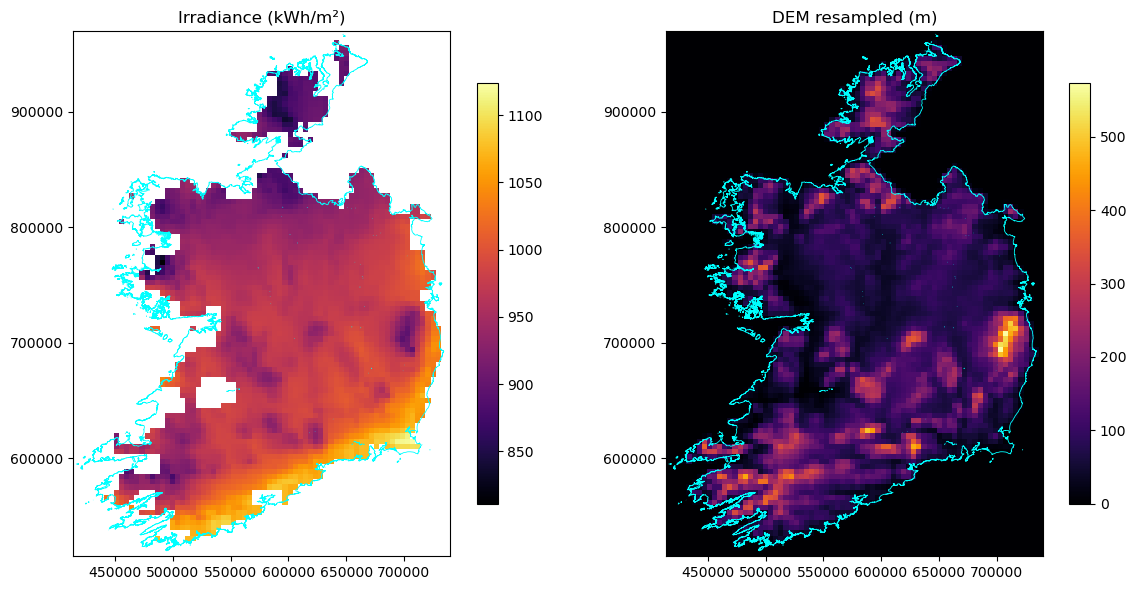

In [3]:
boundary = load_region_boundary(DATA['boundary'], target_crs='EPSG:2157')

with rasterio.open(DATA['irr']) as irr, rasterio.open(DATA['dem_resampled']) as dem:
    irr_data = np.ma.masked_equal(irr.read(1), irr.nodata)
    dem_data = np.ma.masked_equal(dem.read(1), dem.nodata)
    irr_vmin, irr_vmax = np.nanpercentile(irr_data.compressed(), (0, 100))
    dem_vmin, dem_vmax = np.nanpercentile(dem_data.compressed(), (0, 100))
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for ax, data, vmin, vmax, title in (
        (axes[0], irr_data, irr_vmin, irr_vmax, 'Irradiance (kWh/m²)'),
        (axes[1], dem_data, dem_vmin, dem_vmax, 'DEM resampled (m)'),
    ):
        im = ax.imshow(
            data,
            extent=[irr.bounds.left, irr.bounds.right, irr.bounds.bottom, irr.bounds.top],
            vmin=vmin,
            vmax=vmax,
            cmap='inferno',
        )
        boundary.boundary.plot(ax=ax, color='cyan', linewidth=0.6)
        ax.set_title(title)
        fig.colorbar(im, ax=ax, shrink=0.8)
    plt.tight_layout()
    out_path = ROOT / 'data/interim/explore_preview.png'
    plt.savefig(out_path, dpi=200)
    print(f'Saved preview to: {out_path}')
    plt.show()
    plt.close(fig)


## 4. 文字小结
- 辐照度（4.4km，EPSG:2157）值域约 8xx–11xx kWh/m²，覆盖研究区；
- DEM 原始 23m，已重采样到 4.4km 网格对齐辐照度；
- 坡度基于 DEM 计算并聚合到 4.4km，掩膜与辐照度一致；
- 当前分析以辐照度分辨率为基准，后续特征建议在同一网格计算或聚合。


## 5. Slope on irradiance grid (4.4 km)


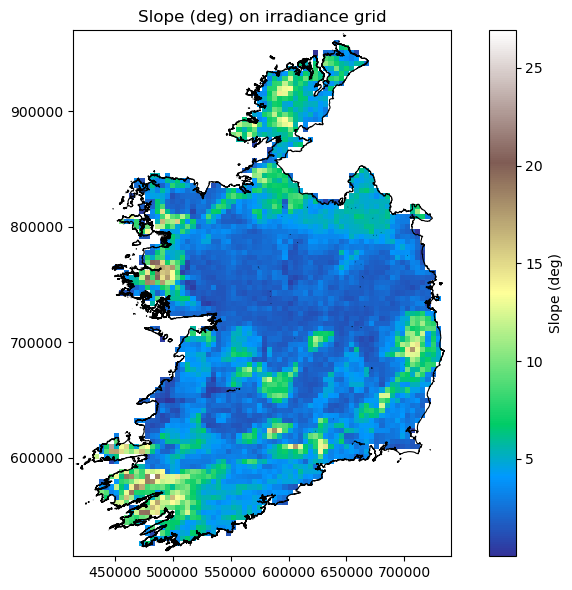

In [4]:
boundary = load_region_boundary(DATA['boundary'], target_crs='EPSG:2157')
with rasterio.open(DATA['slope']) as ds:
    arr = np.ma.masked_equal(ds.read(1), ds.nodata)
    extent = (ds.bounds.left, ds.bounds.right, ds.bounds.bottom, ds.bounds.top)

plt.figure(figsize=(8, 6))
img = plt.imshow(arr, cmap='terrain', extent=extent)
boundary.boundary.plot(ax=plt.gca(), color='black', linewidth=0.8)
plt.colorbar(img, label='Slope (deg)')
plt.title('Slope (deg) on irradiance grid')
plt.tight_layout()
plt.show()


top10 类别 (value, count, percent%):
18 | 1963 | 54.71%
36 | 468 | 13.04%
21 | 250 | 6.97%
24 | 165 | 4.60%
12 | 147 | 4.10%
29 | 115 | 3.21%
2 | 66 | 1.84%
41 | 65 | 1.81%
27 | 63 | 1.76%
44 | 61 | 1.70%


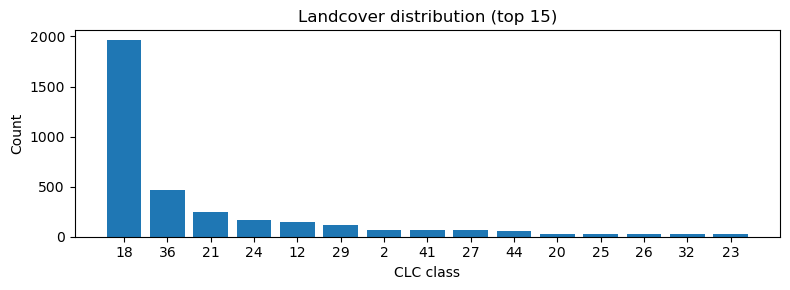

In [5]:
# 小步目标：加载对齐后的土地利用，输出 top10 类别并画柱状图。
# 输入：data/interim/landcover_resampled_to_irradiance.tif。
# 输出：打印 top10，占比；显示前15类别柱状图。
from src.features import load_landcover
import numpy as np
import matplotlib.pyplot as plt

arr, _ = load_landcover()  # 读取土地利用
valid = arr.compressed()                                   # 取有效分类值
vals, counts = np.unique(valid, return_counts=True)        # 统计频次
order = np.argsort(counts)[::-1]                           # 按频次降序
vals, counts = vals[order], counts[order]
print("top10 类别 (value, count, percent%):")
percent = counts / counts.sum() * 100
for v, c, p in zip(vals[:10], counts[:10], percent[:10]):
    print(f"{int(v)} | {c} | {p:.2f}%")

plt.figure(figsize=(8, 3))
plt.bar([str(int(v)) for v in vals[:15]], counts[:15])      # 前15类别柱状图
plt.xlabel("CLC class")
plt.ylabel("Count")
plt.title("Landcover distribution (top 15)")
plt.tight_layout()
plt.show()
